In [1]:
from models.HurdlePoisson import ZeroKInflatedPoisson
from generate_hnb import generate_hnb
from generate_ZI import generate_ZI
from models.ZKIP import ZKIP_EM
from models.ZkICMP import ZkICMP
from models.ZKINB import ZkINB_EM
from models.ZIP import ZIP_EM
from models.ZINB import ZINB_EM

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

1.16


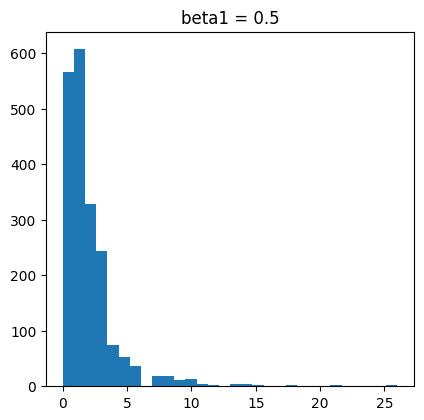

{0.5: 0.283}

In [3]:
# --- Different zero-inflation settings via beta1 ---
beta1_values = [0.5]  # low → high inflation
a1 = 1  # fixed gamma1 for k-inflation
k=3
y_all = {}
X_all = {}
for b1 in beta1_values:
    y = generate_hnb(n=2000, k=3, beta0=-1, beta1=b1, 
                  gamma0=-2, gamma1=0.3, alpha0=0.5, alpha1=a1, r=10, cov_type="nbinary")
    X_all[b1] = y.iloc[:, 1].values
    y_all[b1] = y.iloc[:, 0].values

# --- Plot histograms ---
plt.figure(figsize=(12, 8))
for i, b1 in enumerate(beta1_values):
    plt.subplot(2, 3, i+1)
    plt.hist(y_all[b1], bins=30)
    plt.title(f"beta1 = {b1}")
plt.tight_layout()
plt.show()

# --- Calculate inflation proportions ---
inflation = {b1: np.mean(y_all[b1] == 0) for b1 in beta1_values}
inflation


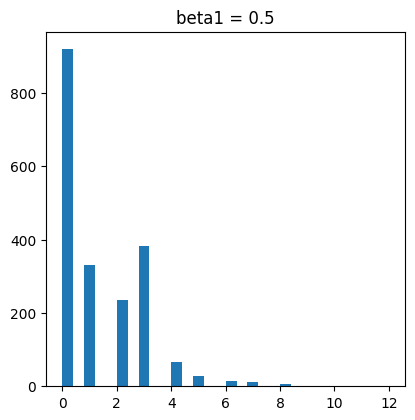

{0.5: np.float64(0.4605)}

In [7]:
# --- Different zero-inflation settings via beta1 ---
beta1_values = [0.5]  # low → high inflation
a1 = 0.2  # fixed gamma1 for k-inflation
k=3
y_all = {}
X_all = {}
for b1 in beta1_values:
    y = generate_ZI(n=2000, k=3, beta0=-1, beta1=b1, 
                  gamma0=-2, gamma1=0.3, alpha0=0.5, alpha1=a1, r=3, cov_type="nbinary")
    X_all[b1] = y.iloc[:, 1].values
    y_all[b1] = y.iloc[:, 0].values

# --- Plot histograms ---
plt.figure(figsize=(12, 8))
for i, b1 in enumerate(beta1_values):
    plt.subplot(2, 3, i+1)
    plt.hist(y_all[b1], bins=30)
    plt.title(f"beta1 = {b1}")
plt.tight_layout()
plt.show()

# --- Calculate inflation proportions ---
inflation = {b1: np.mean(y_all[b1] == 0) for b1 in beta1_values}
inflation


In [4]:
pd.DataFrame(y_all[beta1_values[0]])[0].value_counts()


0
1     608
0     566
2     328
3     243
4      74
5      53
6      36
8      19
7      19
10     14
9      12
11      5
13      5
14      5
26      3
18      3
21      2
12      2
15      2
17      1
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

X=X_all[beta1_values[0]]        
y=y_all[beta1_values[0]]
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
)

In [13]:
import statsmodels.api as sm
sm.add_constant(X_train)

array([[ 1.        ,  0.04298281],
       [ 1.        , -0.54654958],
       [ 1.        , -1.2687503 ],
       ...,
       [ 1.        , -1.38068422],
       [ 1.        ,  0.40761008],
       [ 1.        , -0.13021317]])

In [14]:
X

array([ 1.73111515, -0.98506171,  0.38379606, ..., -0.5115511 ,
       -0.33089744,  2.54233084])

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [14]:
# ZeroKInflatedPoissonHurdle Model
model=ZeroKInflatedPoisson(k=3)
res=model.fit(X_train, y_train)
y_pred=model.predict_mean(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, mae, r2

(5.082835705564934, 1.5650864894097822, 0.10205005162325198)

In [16]:
res.ztp_model

In [ ]:
# ZKIPModel_EM
model=ZKIPModel_EM(k_inflated=3)
model.fit(X_train.reshape(-1, 1), y_train)
y_pred_em=model.predict_expected(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_em)
mae = mean_absolute_error(y_test, y_pred_em)
r2 = r2_score(y_test, y_pred_em)
mse, mae, r2

(2.4115777084217935, 1.3052484986224846, 0.0015537612957903235)

In [8]:
# ZkICMP
model=ZkICMP(k=3)
res=model.fit(X_train.reshape(-1, 1), y_train)
_,_,y_pred_icmp,_=model.predict(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_icmp)
mae = mean_absolute_error(y_test, y_pred_icmp)
r2 = r2_score(y_test, y_pred_icmp)
mse, mae, r2

(5.438548855278374, 1.6046909858606306, 0.03920863338256286)

In [12]:
res.final_loglik

2514.4340394945984

In [11]:
from sklearn.ensemble import RandomForestRegressor 
# RandomForestRegressor
rf = RandomForestRegressor(
        n_estimators=300,
        criterion="poisson",
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    )
rf.fit(X_train.reshape(-1, 1), y_train)
y_pred_rf = rf.predict(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
mse, mae, r2

(2.5761797827984276, 1.3359266598467758, -0.06659511960915632)

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor
# HistGradientBoostingRegressor with Poisson loss
poisson_GB = HistGradientBoostingRegressor(
            loss='poisson',        # This is the key - uses Poisson likelihood
            random_state=42,
            max_iter=100,
            learning_rate=0.1,
            max_depth=6,
            min_samples_leaf=20    # Good for count data to prevent overfitting
        )
poisson_GB.fit(X_train.reshape(-1, 1), y_train)
y_pred_gb = poisson_GB.predict(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
mse, mae, r2

(2.416680893950717, 1.304960539350613, -0.0005590698101571867)

In [17]:
model = ZkINB_EM()
res = model.fit_em(y_train, X_train.reshape(-1, 1), X_train.reshape(-1, 1), k)
y_pred_inb=model.predict(X_test.reshape(-1, 1), X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_inb)
mae = mean_absolute_error(y_test, y_pred_inb) 
r_2 = r2_score(y_test, y_pred_inb)  
mse, mae, r_2

(5.805373003091505, 1.5048508399400544, -0.025595689179253256)

In [18]:
res

{'n_iter': 6,
 'converged': True,
 'history': {'ll': [-3252.628397221076,
   -3195.302043711299,
   -3189.327230503602,
   -3188.963488212627,
   -3188.9452444970166,
   -3188.9443712283864],
  'gamma0': [array([0.11060548]),
   array([0.67316419]),
   array([0.86528401]),
   array([0.91479414]),
   array([0.92612902]),
   array([0.92863017])],
  'gammak': [array([0.05245648]),
   array([0.45508461]),
   array([0.56138548]),
   array([0.58805823]),
   array([0.59420222]),
   array([0.59556527])],
  'beta': [array([0.64772028]),
   array([0.79725178]),
   array([0.85810812]),
   array([0.87309595]),
   array([0.87636155]),
   array([0.87706468])],
  'alpha': [0.6086141328254057,
   0.450090106651641,
   0.3874099283662905,
   0.37272420749365925,
   0.36959818174337905,
   0.3689307439657813]},
 'gamma0': array([0.92863017]),
 'gammak': array([0.59556527]),
 'beta': array([0.87706468]),
 'alpha': 0.3689307439657813,
 'k': 3,
 'final_loglik': -3188.9452444970166}

In [11]:
#ZIP
beta, gamma = ZIP_EM(y_train, X_train.reshape(-1, 1), X_train.reshape(-1, 1))
mean_pred = predict_mean(X_test.reshape(-1, 1), X_test.reshape(-1, 1), beta, gamma)
mse = mean_squared_error(y_test, mean_pred)
mae = mean_absolute_error(y_test, mean_pred)
r_2 = r2_score(y_test, mean_pred)
mse, mae, r_2

-3875.2864302815096
-3219.299044481035
-3202.835095486059
-3202.6616669927857
-3202.6594177562883
-3202.6593885377238


(8.190268518478666, 1.8339121190014815, -0.21069513592457834)

In [8]:
#ZINB
alpha=1/10
beta, gamma = ZINB_EM(y_train, X_train.reshape(-1, 1), X_train.reshape(-1, 1), alpha) # alpha is a problem
mean_pred = predict_mean(X_test.reshape(-1, 1), X_test.reshape(-1, 1), beta, gamma)
mse = mean_squared_error(y_test, mean_pred)
mae = mean_absolute_error(y_test, mean_pred)
r_2 = r2_score(y_test, mean_pred)
mse, mae, r_2

-3178.446618296784
-3166.755915825262
-3166.6377382652427
-3166.6365618362397
-3166.6365501920973
-3166.6365500777415


NameError: name 'predict_mean' is not defined